### <center>M2 SID - Analyse et exploitation de données</center>
# <center>Image - TP2 : Indexation d'images par le contour</center>
## <center>Emma Grandgirard</center>

In [1]:
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import *
import numpy as np
import os
from copy import copy
from PIL import Image

root_path = os.getcwd()
os.chdir(os.path.join(os.getcwd(), 'Images'))
list_images = os.listdir()

## 1. Extraction du contour

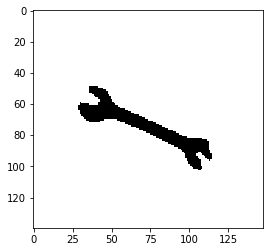

In [3]:
img = imread(list_images[0])
plt.imshow(img, cmap='Greys_r')

In [4]:
# Fonction pour la détection de contours (algo de la tortue)
def contour_tortue(img):

    # 1. Initialisation
    direction = 1  # vers la droite
    nbpoints = 0  # Nombre de points sur le contour
    contourX = []
    contourY = []

    # 2. Recherche du premier pixel noir - on suppose qu'il y en a au moins 1 !
    s = img.shape
    imgcontour = copy(img)
    i = 0
    j = 0
    while img[i][j] != 0:
        i = i + 1
        if i > s[0]-1:
            i = 0
            j = j + 1

    # 3. Repérage du point_depart
    p = []
    p.append(i)
    p.append(j)
    point_depart = copy(p)

    # 4. direction_courante = direction
    direction_courante = direction

    # 5. Sélectionner le voisin q de p dans la direction_courante indiquée par le code de freeman
    # on suppose qu'il existe
    boucle = 0
    while not boucle:
        boucle = 1
        voisin = 0
        while not voisin:
            voisin = 1
            q = copy(p)
            if direction_courante == 0:
                q[1] = q[1] + 1
            if direction_courante == 1:
                q[0] = q[0] - 1
                q[1] = q[1] + 1
            if direction_courante == 2:
                q[0] = q[0] - 1
            if direction_courante == 3:
                q[0] = q[0] - 1
                q[1] = q[1] - 1
            if direction_courante == 4:
                q[1] = q[1] - 1
            if direction_courante == 5:
                q[0] = q[0] + 1
                q[1] = q[1] - 1
            if direction_courante == 6:
                q[0] = q[0] + 1
            if direction_courante == 7:
                q[0] = q[0] + 1
                q[1] = q[1] + 1

            # 6. Si q n'est pas un point de la région
                # ou s'il n'est pas voisin d'un pixel blanc (connexité 4V)
                # ou s'il a deja ete identifie comme un point du contour alors
            if ((int(img[q[0]-1][q[1]]) + int(img[q[0]+1][q[1]]) + int(img[q[0]][q[1]-1]) + int(img[q[0]][q[1] + 1])) == 0) or (int(img[q[0]][q[1]]) != 0) or (int(imgcontour[q[0]][q[1]]) == 128):
                # Si ce n'est le point de depart alors changement de direction et retour en 5
                if not ((q[0] == point_depart[0]) and (q[1] == point_depart[1])):
                    # On tourne dans le sens des aiguilles d'une montre
                    direction_courante = (direction_courante + 7) % 8
                    voisin = 0

        # 7. Marquer p comme etant un point du contour
        nbpoints = nbpoints + 1
        contourX.append(p[0])
        contourY.append(p[1])

        imgcontour[contourX[-1], contourY[-1]] = 128

        # 8. direction = direction_courante
        direction = direction_courante
        # On cherchera le voisin suivant le plus "a gauche"
        direction_courante = (direction_courante + 3) % 8

        # 9. p = q
        p[0] = q[0]
        p[1] = q[1]

        # 10. Tant que p est différent de point_depart alors retourner en 5.
        boucle = (p[0] == point_depart[0]) * (p[1] == point_depart[1])

    return contourY, contourX  # colonne, ligne

In [5]:
contourX, contourY = contour_tortue(
    np.array(Image.open(os.path.join(root_path, '51.bmp'))))

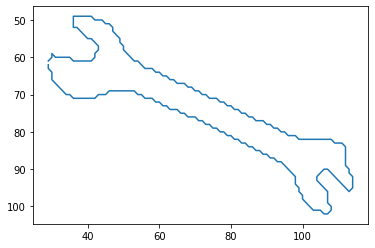

In [6]:
plt.plot(contourX, contourY)
plt.gca().invert_yaxis()

## 2. Calcul de la fonction de courbure

In [7]:
def phi(contourX, contourY, ind, c):
    '''
    Fonction de courbure
    '''
    res = np.arctan((contourY[ind]-contourY[ind-c]) /
                    (contourX[ind]-contourX[ind-c]+0.0000001))
    return res

In [8]:
def courbure(contourX, contourY, c):
    '''
    Application de la fonction de courbure à chaque point du contour
    '''
    res_courbure = []
    phis = [phi(contourX, contourY, ind, c) for ind in range(len(contourX))]
    for i in range(1, len(phis)):
        res_courbure.append(phis[i]-phis[i-1])
    return res_courbure

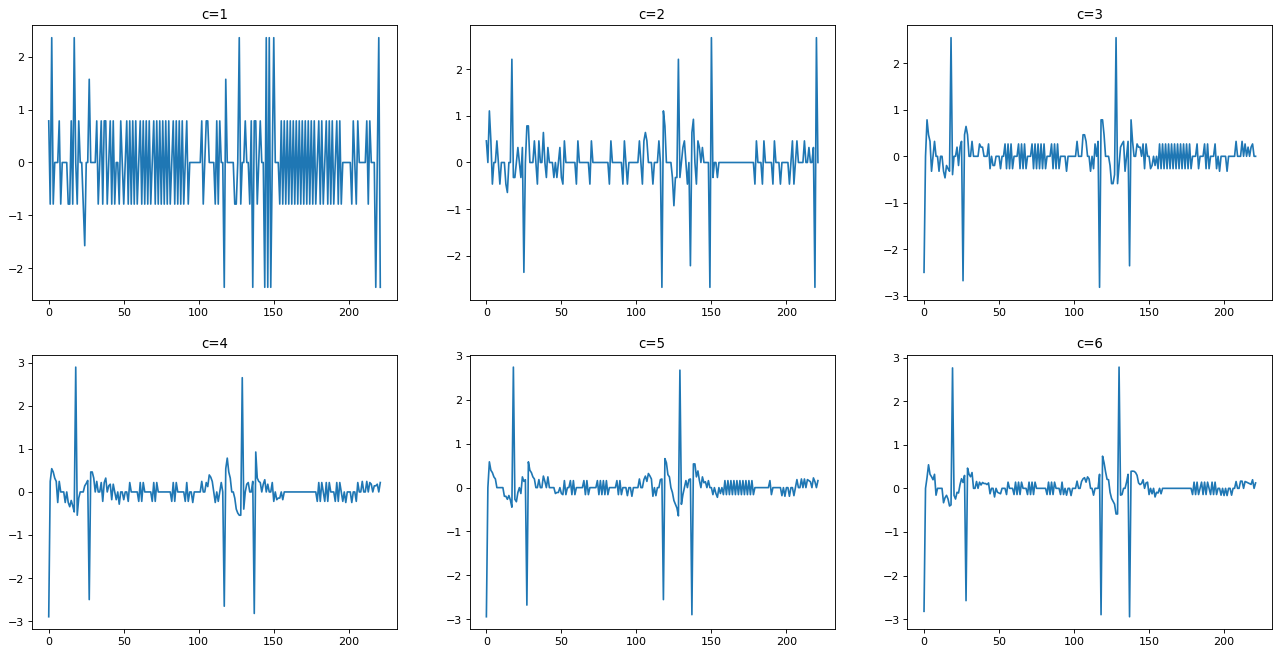

In [9]:
plt.figure(0, figsize=(20, 10), dpi=80)
c = 1
for i in range(2):
    for j in range(3):
        ax = plt.subplot2grid((2, 3), (i, j))
        # affichage de la fonction de courbure
        plt.plot(courbure(contourX, contourY, c))
        ax.set_title('c=' + str(c))
        c += 1
plt.show()

➡ Les pics correspondent à des changements de direction. On constate qu'à partir de c=4 le nombre de pics (6) ne change plus.

## 3. Indexation de contours

In [10]:
def descripteur_fourier(img, c, len_tr, ind_crop):
    '''
    In: image, c, longueur de la transformée, nombre d'éléments de la transformée conservés
    Out: log énergie moyenne pour chaque bloc
    '''
    contourX, contourY = contour_tortue(np.array(Image.open(img)))
    k_vect = courbure(contourX, contourY, c)
    FFT = np.abs(np.fft.fft(k_vect, len_tr))
    FFT = FFT[0:ind_crop]
    return FFT

In [11]:
def indexation(path_images, c, len_tr, ind_crop):
    '''
    Création des descripteurs de chaque image
    '''
    list_images = os.listdir(path_images)
    signatures_list = []
    for k in range(len(list_images)):
        img = list_images[k]
        signatures_list.append(descripteur_fourier(img, c, len_tr, ind_crop))
    return signatures_list

In [12]:
def manhattan_dist(v1, v2):
    '''
    Distance de Manhattan entre deux vecteurs
    '''
    return np.sum(np.abs(np.array(v1)-np.array(v2)))

In [13]:
def most_simil(ind_img, nb_img, signatures_list):
    '''
    In: indice de l'image de référence, nombre d'images similaires souhaitées, liste des descripteurs des images
    Out: indices des images similaires
    '''
    c_ref = signatures_list[ind_img-51]  # descripteur de l'image de référence

    dists_man = []
    for k in range(len(signatures_list)):  # pour chaque image
        # descripteur de l'image à laquelle on compare l'image de référence
        c1 = signatures_list[k]
        dist_man = manhattan_dist(c_ref, c1)  # distance de manhattan
        if k != ind_img - 51:
            dists_man.append(dist_man)
        else:
            # l'image de référence ne devra pas apparaître dans la liste d'images similaires
            dists_man.append(100000000)

    M = dists_man.copy()
    indice_min = []  # vecteur qui contiendra les indices des images les plus semblables à l'image de référence

    for j in range(0, nb_img):
        ind = np.argmin(M)  # on relève l'indice du minimum de M
        indice_min.append(ind+51)  # on ajoute cet indice au vecteur indice_min
        # on remplace le minimum dans M afin de pouvoir itérer en cherchant un nouveau minimum
        M[ind] = 100000000

    return indice_min

In [14]:
def display_most_simil(ind_img, nb_img, signatures_list, list_images):
    '''
    In: indice de l'image de référence, nombre d'images similaires souhaitées, liste des descripteurs des images
    Out: affichage de l'image et des images similaires avec leurs indices
    '''
    if nb_img > 3 or nb_img < 1:
        print('nb_img must be <=3 and >0')

    else:
        path_img = list_images[ind_img-51]

        # indices des images les plus similaires
        list_most_simil = most_simil(ind_img, nb_img, signatures_list)

        plt.figure(figsize=(16, 10), dpi=80)
        k = 0
        img_ref = imread(path_img)
        plt.subplot(351 + k)
        axis('off')
        # affichage de l'image de référence
        plt.imshow(img_ref, cmap='Greys_r')
        plt.title(str(ind_img) + ' (req)')
        k += 1

        # affichage des images
        for i in list_most_simil:
            path_img = list_images[i-51]
            img = imread(path_img)
            plt.subplot(351+k)
            axis('off')
            plt.imshow(img, cmap='Greys_r')
            plt.title(i)
            k += 1

### Recherche des meilleurs paramètres d'indexation

In [15]:
def find_best_combs(ind_img_ref, ind_img_sim1, ind_img_sim2, nb_im_sim):
    '''
    In: indice de l'image de référence, indice des images de la même famille (ex toutes les clés, toutes les mains, etc.),
        nombre d'images de la même famille (1 ou 2 ici)
    Out: paires [c, ind_crop] permettant de retrouver la similarité entre l'image de référence et les images de sa famille
    '''
    best_comb = []
    for c in range(15):  # on teste différentes valeurs de c
        # différentes valeurs de ind_crop (nombre d'éléments de la transformée de Fourier conservés)
        for ind_crop in range(2, 16):
            signatures_list = indexation(
                '', c=c, len_tr=128, ind_crop=ind_crop)
            if ind_img_sim1 and ind_img_sim2 in most_simil(ind_img_ref, nb_im_sim, signatures_list):
                best_comb.append([c, ind_crop])
    return best_comb

In [16]:
# image référence 51 (clé), images de la même famille 52 et 53
best_combs_cle51 = find_best_combs(51, 52, 53, 2)
# image référence 62 (main), image de la même famille 63
best_combs_main62 = find_best_combs(62, 63, 63, 1)
best_combs_lunettes54 = find_best_combs(54, 55, 56, 2)  # etc.
best_combs_lapin59 = find_best_combs(59, 60, 61, 1)
best_combs_buste57 = find_best_combs(57, 58, 58, 1)

In [17]:
print('Meilleures paires (c,ind_crop) pour clé (ref.51) :\n' +
      str(best_combs_cle51)+'\n')
print('Meilleures paires (c,ind_crop) pour main (ref.62) :\n' +
      str(best_combs_main62)+'\n')
print('Meilleures paires (c,ind_crop) pour lunettes (ref.54) :\n' +
      str(best_combs_lunettes54)+'\n')
print('Meilleures paires (c,ind_crop) pour lapin (ref.59) :\n' +
      str(best_combs_lapin59)+'\n')
print('Meilleures paires (c,ind_crop) pour buste (ref.57) :\n' +
      str(best_combs_buste57)+'\n')

Meilleures paires (c,ind_crop) pour clé (ref.51) :
[[0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [0, 12], [0, 13], [0, 14], [0, 15], [8, 5], [8, 6], [9, 5], [9, 6], [9, 9], [9, 10], [9, 12], [10, 6], [10, 9], [10, 10], [11, 5], [11, 6], [11, 9], [11, 10], [11, 12], [13, 3], [13, 8], [13, 9], [13, 10], [13, 11], [13, 13], [13, 14], [14, 3], [14, 9], [14, 10], [14, 14], [14, 15]]

Meilleures paires (c,ind_crop) pour main (ref.62) :
[[1, 3], [1, 5], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [9, 15]]

Meilleures paires (c,ind_crop) pour lunettes (ref.54) :
[[1, 4], [1, 5], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [2, 15]]

Meilleures paires (c,ind_crop) pour lapin (ref.59) :
[[5, 3], [5, 5], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [6, 10], [7, 2], [7, 4], [7, 5], [7, 6], [7, 7], [7, 8], [7, 9], [7, 10], [7, 11], [7, 12], [7, 13], [7, 14], [7, 15], [8, 2], [8, 4], [8, 5], [8, 6], [8, 7], [8, 8], [8, 9], [8, 1

### Affichage des résultats obtenus avec les meilleures paires [c,ind_crop]

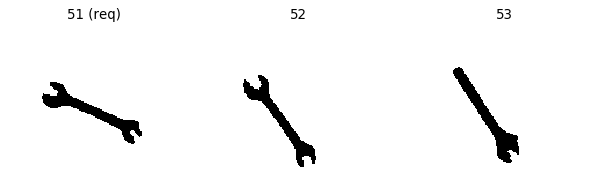

In [18]:
signatures_list = indexation('', c=14, len_tr=128, ind_crop=3)
display_most_simil(51, 2, signatures_list, list_images)

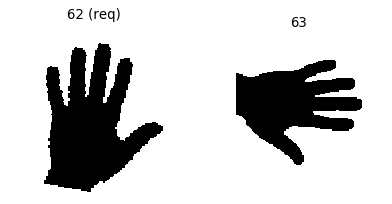

In [19]:
signatures_list = indexation('', c=9, len_tr=128, ind_crop=15)
display_most_simil(62, 1, signatures_list, list_images)

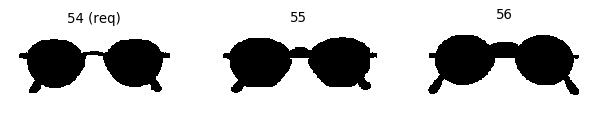

In [20]:
signatures_list = indexation('', c=2, len_tr=128, ind_crop=15)
display_most_simil(54, 2, signatures_list, list_images)

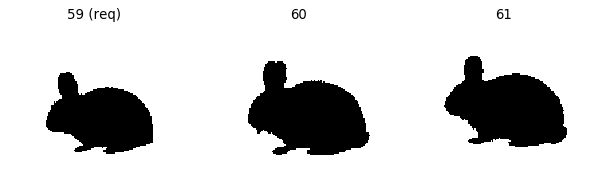

In [21]:
signatures_list = indexation('', c=2, len_tr=128, ind_crop=14)
display_most_simil(59, 2, signatures_list, list_images)

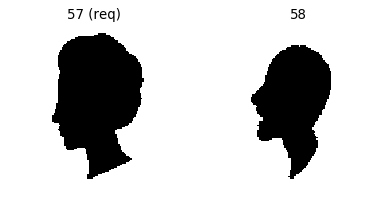

In [22]:
signatures_list = indexation('', c=3, len_tr=128, ind_crop=8)
display_most_simil(57, 1, signatures_list, list_images)